In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import dbscan
import plotly.express as px
from datetime import datetime

In [ ]:
path = 'bank-full.csv'
original_df = pd.read_csv(path, sep=';')

In [ ]:
df = original_df.copy()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# ## Input variables:

# ### bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric)
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")

# ### related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)

# ### other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

# ## Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [ ]:
num_columns = list(df.select_dtypes(include=['int','float']).columns)
cat_columns = list(df.select_dtypes(include=['object','bool','category']).columns)

print("Number of numerical columns:", len(num_columns))
print("Number of categorical columns:", len(cat_columns))
print("Total number of columns in the feature dataframe:", df.shape[1])

Number of numerical columns: 7
Number of categorical columns: 10
Total number of columns in the feature dataframe: 17


## clear data

In [ ]:
# features default, housing, loan and y to binary
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [ ]:
# one-hot encoding for categorical features
encoded_df = pd.get_dummies(df, columns=cat_columns)

In [ ]:
def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [ ]:
# Remove outliers for each numeric column
for column in num_columns:
    encoded_df = remove_outliers_iqr(encoded_df, column)

In [ ]:
encoded_df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_0,default_1,housing_0,housing_1,loan_0,loan_1,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


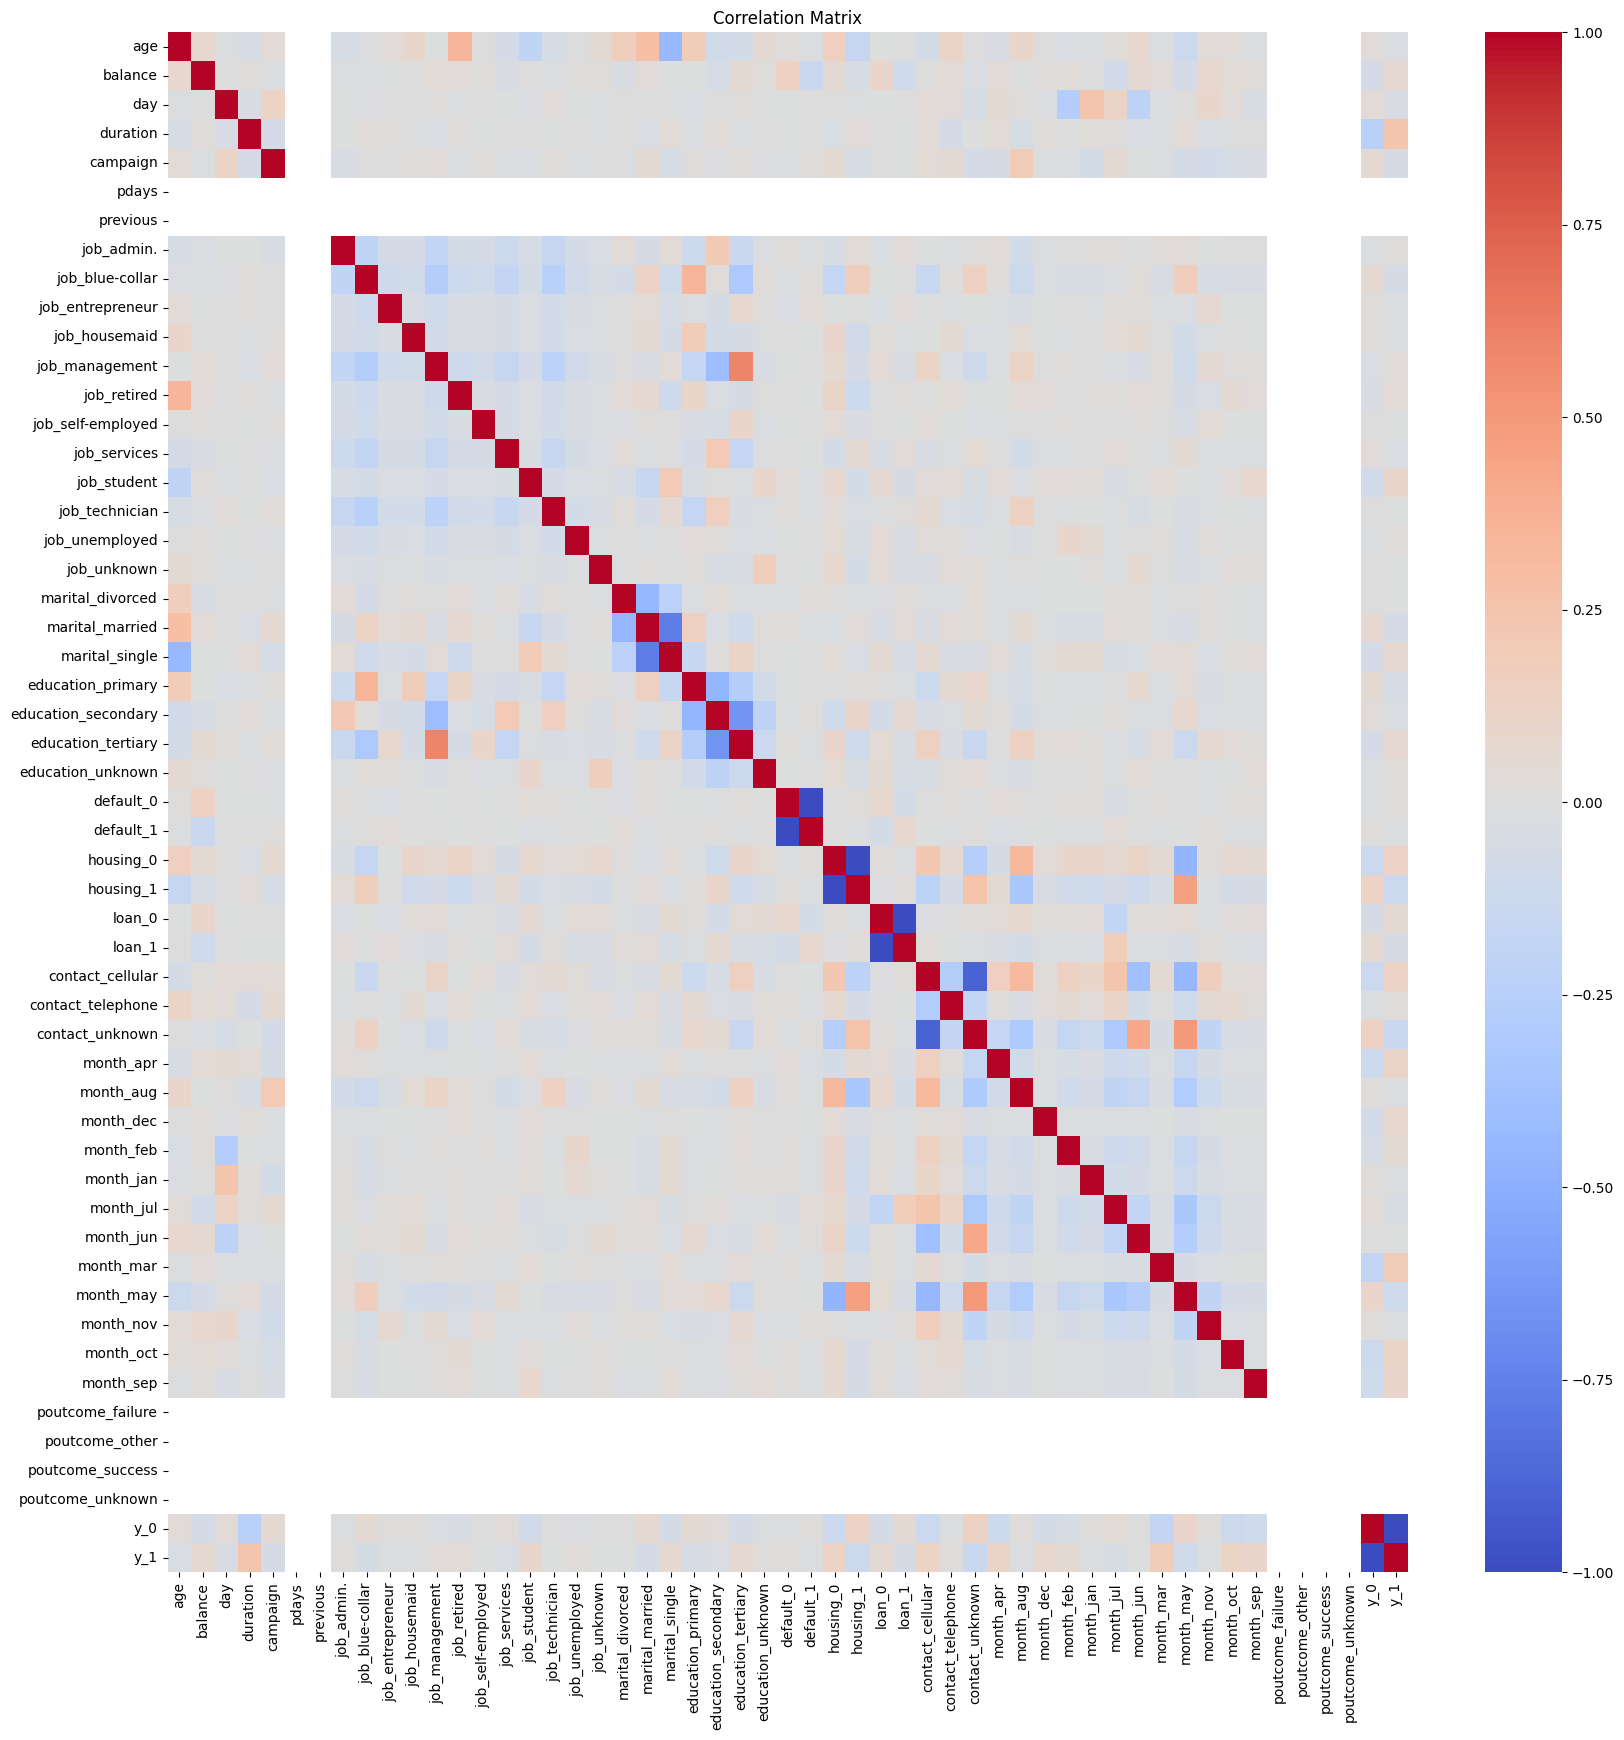

In [ ]:
corr_matrix = encoded_df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#RFM

In [ ]:
finaldf = encoded_df.copy()
finaldf.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_0,default_1,housing_0,housing_1,loan_0,loan_1,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,y_0,y_1
0,58,2143,5,261,1,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,44,29,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,33,2,5,76,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
3,47,1506,5,92,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
4,33,1,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0


In [ ]:
rfmtable = pd.DataFrame()
rfmtable['R'] = finaldf['pdays']
rfmtable['F'] = finaldf['campaign']
rfmtable['M'] = finaldf['balance']
rfmtable.head()

,R,F,M
0,-1,1,2143
1,-1,1,29
2,-1,1,2
3,-1,1,1506
4,-1,1,1


In [ ]:
rfmtable["R_score"] = pd.qcut(rfmtable['R'].rank(method="first"), 5, labels=[5, 4, 3, 2, 1])


rfmtable["F_score"] = pd.qcut(rfmtable['F'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfmtable["M_score"] = pd.qcut(rfmtable['M'], 5, labels=[1, 2, 3, 4, 5])

rfmtable['score']=rfmtable['R_score'].astype(int)+rfmtable['F_score'].astype(int)+rfmtable['M_score'].astype(int)


rfmtable.head()

,R,F,M,R_score,F_score,M_score,score
0,-1,1,2143,5,1,5,11
1,-1,1,29,5,1,2,8
2,-1,1,2,5,1,1,7
3,-1,1,1506,5,1,5,11
4,-1,1,1,5,1,1,7


In [ ]:
def rfm_scores(score):
    if  ((score >1) and (score < 4)):
        return '4'
    elif ((score >3) and (score < 8)):
        return '3'
    elif ((score > 7) and (score <11)):
        return '2'
    else:
        return '1'

In [ ]:
rfmtable['Cluster'] = rfmtable['score'].apply(lambda score : rfm_scores(score))
rfmtable.head()

,R,F,M,R_score,F_score,M_score,score,Cluster
0,-1,1,2143,5,1,5,11,1
1,-1,1,29,5,1,2,8,2
2,-1,1,2,5,1,1,7,3
3,-1,1,1506,5,1,5,11,1
4,-1,1,1,5,1,1,7,3


In [ ]:
rfmtable["F_score"]= pd.to_numeric(rfmtable["F_score"])
rfmtable["M_score"] = pd.to_numeric(rfmtable["M_score"])
rfmtable["R_score"]= pd.to_numeric(rfmtable["R_score"])
rfmtable.groupby("Cluster")[["R_score", "F_score", "M_score"]].mean()

,R_score,F_score,M_score
Cluster,,,
1,3.78,3.97,4.09
2,2.99,2.97,3.03
3,2.26,2.10,1.86


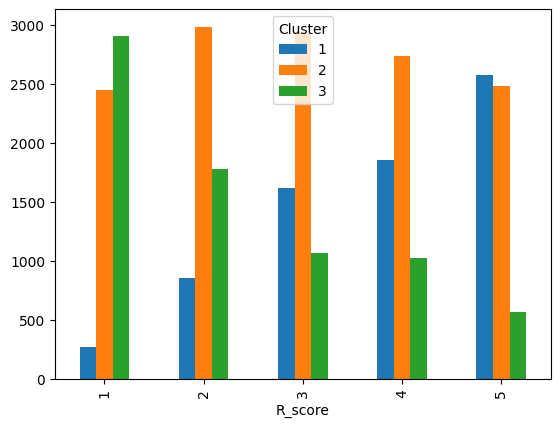

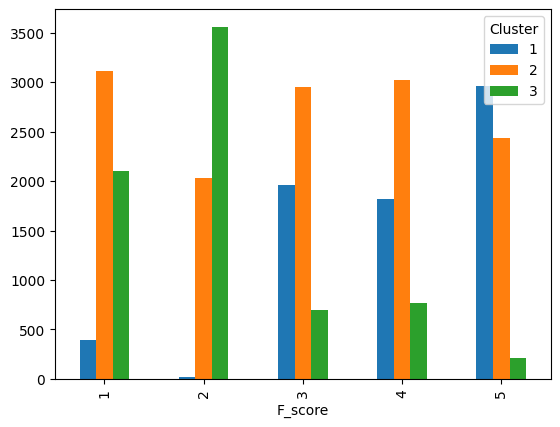

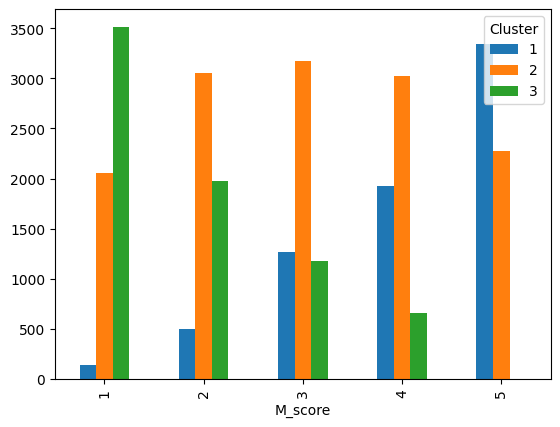

In [ ]:
crosstb1=pd.crosstab(rfmtable['R_score'], rfmtable['Cluster'])
barplot1 = crosstb1.plot.bar()
crosstb2=pd.crosstab(rfmtable['F_score'], rfmtable['Cluster'])
barplot2 = crosstb2.plot.bar()
crosstb3=pd.crosstab(rfmtable['M_score'], rfmtable['Cluster'])
barplot3 = crosstb3.plot.bar()

In [ ]:
from collections import Counter
c = Counter(list(rfmtable['Cluster']))
c

Counter({'1': 7164, '2': 13572, '3': 7333})

In [ ]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


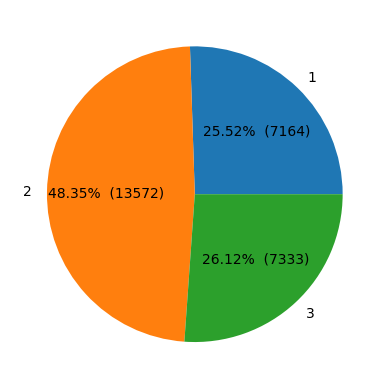

In [ ]:
pr1 = list(c.values())
pr2 = list(c.keys())
plt.pie(pr1, labels=pr2, autopct=make_autopct(pr1))
plt.show()

In [ ]:
rfmlabel = finaldf.copy()
rfmlabel['Cluster'] = rfmtable['Cluster']

In [ ]:
list4 = list(rfmlabel.loc[rfmlabel['Cluster'] == "4"].mean())
for i in range(len(list4)):
  list4[i] = str(list4[i])[0:7]

In [ ]:
rmfbylable = pd.DataFrame({'features': list(rfmlabel)})
rmfbylable['Very active mean'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "1"].mean())
rmfbylable['Active mean'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "2"].mean())
rmfbylable['Middle active mean'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "3"].mean())
rmfbylable['Not active'] = list4


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'right')
pd.set_option('display.precision', 5)

rmfbylable

,features,Very active mean,Active mean,Middle active mean,Not active
0,age,41.43760,40.34004,39.35743,nan
1,balance,1193.44612,575.04649,76.07746,nan
2,day,16.15969,15.77395,15.38484,nan
3,duration,201.32803,206.02888,203.56553,nan
4,campaign,3.20436,2.13749,1.29347,nan
5,pdays,-1.00000,-1.00000,-1.00000,nan
6,previous,0.00000,0.00000,0.00000,nan
7,job_admin.,0.10343,0.11428,0.13092,nan
8,job_blue-collar,0.26186,0.21788,0.20496,nan
9,job_entrepreneur,0.03559,0.03286,0.03559,nan


In [ ]:
rmfbylable2 = pd.DataFrame({'features': list(rfmlabel)})
rmfbylable2['Very active median'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "1"].median())
rmfbylable2['Active median'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "2"].median())
rmfbylable2['Middle active median'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "3"].median())
rmfbylable2['Not active median'] = list(rfmlabel.loc[rfmlabel['Cluster'] == "4"].median())


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.colheader_justify', 'right')
pd.set_option('display.precision', 2)

rmfbylable2

,features,Very active median,Active median,Middle active median,Not active median
0,age,41.0,39.0,37.0,NaN
1,balance,1029.0,324.0,9.0,NaN
2,day,16.0,16.0,16.0,NaN
3,duration,165.0,169.0,170.0,NaN
4,campaign,3.0,2.0,1.0,NaN
5,pdays,-1.0,-1.0,-1.0,NaN
6,previous,0.0,0.0,0.0,NaN
7,job_admin.,0.0,0.0,0.0,NaN
8,job_blue-collar,0.0,0.0,0.0,NaN
9,job_entrepreneur,0.0,0.0,0.0,NaN
